# MLP

Use one neuron and selected K-mers.

## Environment setup

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-10-20 13:54:00.826253
Python 3.10.0
sklearn 1.1.2


In [2]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import Dense
from keras.layers import LayerNormalization

dt='float32'
tf.keras.backend.set_floatx(dt)

tf.random.set_seed(42) # reproducible training sessions?

from KmerCounter import KmerCounter
ALPHABET_SIZE=4
K=4
counter=KmerCounter(K)
VOCABULARY_SIZE = counter.get_vocabulary_size() 
print('K=',K,'alphabet size=',ALPHABET_SIZE,'vocabulary size=',VOCABULARY_SIZE)
from TrainValidSplit2 import Splitter2
EPOCHS=5
from cell_lines import Cell_Lines
CELL_LINE_NUMBER = 0

K= 4 alphabet size= 4 vocabulary size= 256


In [3]:
ATLAS_DIR = '/Users/jasonmiller/WVU/Localization/LncAtlas/'
RCI_FILE = 'CNRCI_coding_train_genes.csv'
GENCODE_DIR = '/Users/jasonmiller/WVU/Localization/GenCode/'
COUNTS_FILE='CNRCI_coding_train_counts.K4.csv'

In [4]:
# Consider a Cell_Lines object to represent today's cell line.
all_cell_lines = Cell_Lines.get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 0 = A549


## Model design

In [5]:
def build_model():
    # Here is the joke model -- one neuron!
    mlp = keras.models.Sequential()
    one_layer = keras.layers.Dense(1, activation='sigmoid',dtype=dt,
                                      input_dim=VOCABULARY_SIZE)
    mlp.add(one_layer)
      
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    print("COMPILE...")
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    print("...COMPILED")
    return mlp

In [6]:
# Model setup
print(datetime.now())
model=build_model()
print ("Summarize the model")
print(model.summary())  # Print this only once

2022-10-20 13:54:13.566961
COMPILE...
...COMPILED
Summarize the model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________
None


2022-10-20 13:54:13.574287: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load the data

In [7]:
# Data setup
print(datetime.now())
Kmer_counts_filepath = GENCODE_DIR+COUNTS_FILE
atlas_filepath = ATLAS_DIR+RCI_FILE

splitter=Splitter2()
splitter.load_counts_universe(Kmer_counts_filepath)
universe = splitter.get_gene_universe(atlas_filepath, CELL_LINE_NUMBER)
print(datetime.now())

2022-10-20 13:54:13.687635
Loaded values for cell line 0
Selected 10354 values out of 13930
2022-10-20 13:54:16.877445


## Train and validate with all K-mer counts

In [8]:
def list_Kmers_with_extreme_weights(weights):
    show_kmer = 'AAAA'
    MIN = -0.1
    MAX = 0.1
    pairs = []
    for i in range(len(weights)):
        val = float(weights[i])
        pair = (show_kmer,val,i)
        pairs.append(pair)
        show_kmer = counter.next_kmer(show_kmer)  # assume global counts
    ms = [x[0] for x in pairs if (x[1]< MIN or x[1]> MAX) ]
    print('Extreme K-mers',ms)
    #ws = [x[1] for x in pairs if (x[1]< MIN or x[1]> MAX) ]
    #print('Their weights',ws)
    indices = [x[2] for x in pairs if (x[1]< MIN or x[1]> MAX) ]
    #print('Their indices',indices)
    return indices

splitting
2022-10-20 13:54:16.944545
Train sizes 12019 12019
Valid sizes 2795 2795
Thresholds (-1.266972910885237, 1.1401767974371442)
Train set ones/size 5469 / 12019
Valid set ones/size 1418 / 2795
BUILD MODEL
COMPILE...
...COMPILED
FIT
2022-10-20 13:54:17.091834
Epoch 1/5
376/376 [==============================] - 1s 2ms/step - loss: 1.1294 - accuracy: 0.7267
Epoch 2/5
376/376 [==============================] - 1s 2ms/step - loss: 0.5720 - accuracy: 0.7795
Epoch 3/5
376/376 [==============================] - 1s 2ms/step - loss: 0.4991 - accuracy: 0.7967
Epoch 4/5
376/376 [==============================] - 1s 2ms/step - loss: 0.4416 - accuracy: 0.8146
Epoch 5/5
376/376 [==============================] - 1s 2ms/step - loss: 0.4148 - accuracy: 0.8270


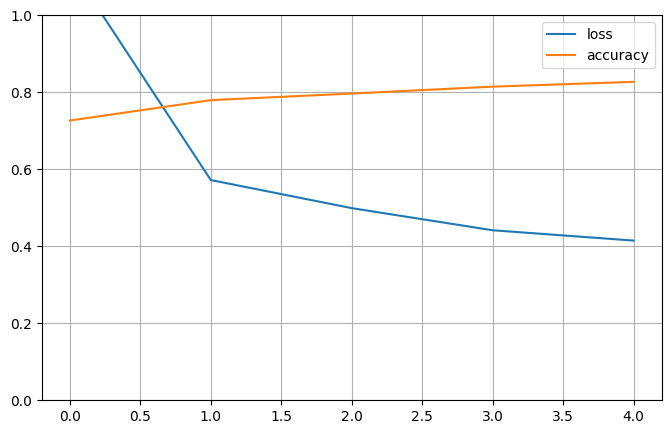

accuracy: 83.04%
2022-10-20 13:54:21.382328


In [9]:
print('splitting')
print(datetime.now())
data_partitions = splitter.get_train_valid_partitions(universe)
one_partition =data_partitions[0]
train_genes,valid_genes = one_partition[0],one_partition[1]
thresholds = splitter.choose_thresholds(train_genes,'one_z')
X_train,y_train = splitter.get_X_y(train_genes, thresholds)
X_valid,y_valid = splitter.get_X_y(valid_genes, thresholds)
print('Train sizes',len(X_train),len(y_train))
print('Valid sizes',len(X_valid),len(y_valid))

print('Thresholds',thresholds)
print('Train set ones/size',
      np.count_nonzero(y_train),'/',len(y_train))
print('Valid set ones/size',
      np.count_nonzero(y_valid),'/',len(y_valid))

print("BUILD MODEL")
model=build_model()

print("FIT")
print(datetime.now())
history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
        epochs=EPOCHS, verbose=1)  # verbose=1 for ascii art, verbose=0 for none
        #validation_data=(X_valid,y_valid) )

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

scores = model.evaluate(X_valid, y_valid, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print(datetime.now())

In [10]:
# https://www.tensorflow.org/guide/variable
w=model.trainable_weights[0].numpy()  # weights
b=model.trainable_weights[1].numpy()  # bias
print('bias',b)
print(len(w),'weights min=',min(w),'max=',max(w))
sacred = list_Kmers_with_extreme_weights(w)

bias [0.76812756]
256 weights min= [-0.15011957] max= [0.20966573]
Extreme K-mers ['AAAA', 'AAAC', 'AAAG', 'AAAT', 'AACA', 'AACC', 'AACG', 'AACT', 'AAGA', 'AAGT', 'AATA', 'AATC', 'AATG', 'AATT', 'ACAA', 'ACAC', 'ACAG', 'ACAT', 'ACCA', 'ACCC', 'ACCG', 'ACCT', 'ACGA', 'ACGT', 'ACTA', 'ACTC', 'ACTG', 'ACTT', 'AGAC', 'AGAT', 'AGCA', 'AGCC', 'AGCG', 'AGCT', 'AGGA', 'AGGG', 'AGGT', 'AGTA', 'AGTC', 'AGTG', 'AGTT', 'ATAA', 'ATAC', 'ATAG', 'ATAT', 'ATCA', 'ATCC', 'ATCG', 'ATCT', 'ATGC', 'ATGT', 'ATTA', 'ATTC', 'ATTT', 'CAAA', 'CAAC', 'CAAG', 'CAAT', 'CACA', 'CACC', 'CACG', 'CACT', 'CAGC', 'CAGT', 'CATA', 'CATC', 'CATG', 'CATT', 'CCAA', 'CCAC', 'CCAG', 'CCAT', 'CCCA', 'CCCC', 'CCCG', 'CCCT', 'CCGA', 'CCGC', 'CCGG', 'CCGT', 'CCTA', 'CCTC', 'CCTG', 'CCTT', 'CGAA', 'CGAC', 'CGAG', 'CGAT', 'CGCA', 'CGCC', 'CGCG', 'CGGG', 'CGGT', 'CGTC', 'CGTG', 'CGTT', 'CTAA', 'CTAC', 'CTAG', 'CTAT', 'CTCA', 'CTCC', 'CTCG', 'CTCT', 'CTGA', 'CTGC', 'CTGG', 'CTGT', 'CTTA', 'CTTC', 'CTTG', 'CTTT', 'GAAA', 'GAAC', 'GAAG

## Train and validate with only "top ten" K-mer counts

In [11]:
def zero_unimportant_counts(rows,sacred):
    for r in range(len(rows)):
        for c in range(len(rows[r])):
            if c not in sacred:
                rows[r][c]=0

splitting
2022-10-20 13:54:21.466732
Train sizes 12019 12019
Valid sizes 2795 2795
whacking
2022-10-20 13:54:21.577861
Thresholds (-1.266972910885237, 1.1401767974371442)
Train set ones/size 5469 / 12019
Valid set ones/size 1418 / 2795
BUILD MODEL
COMPILE...
...COMPILED
FIT
2022-10-20 13:54:27.894153
Epoch 1/5
376/376 [==============================] - 1s 2ms/step - loss: 0.7160 - accuracy: 0.7472
Epoch 2/5
376/376 [==============================] - 1s 2ms/step - loss: 0.5443 - accuracy: 0.7873
Epoch 3/5
376/376 [==============================] - 1s 2ms/step - loss: 0.4604 - accuracy: 0.8077
Epoch 4/5
376/376 [==============================] - 1s 2ms/step - loss: 0.4126 - accuracy: 0.8298
Epoch 5/5
376/376 [==============================] - 1s 2ms/step - loss: 0.3922 - accuracy: 0.8393


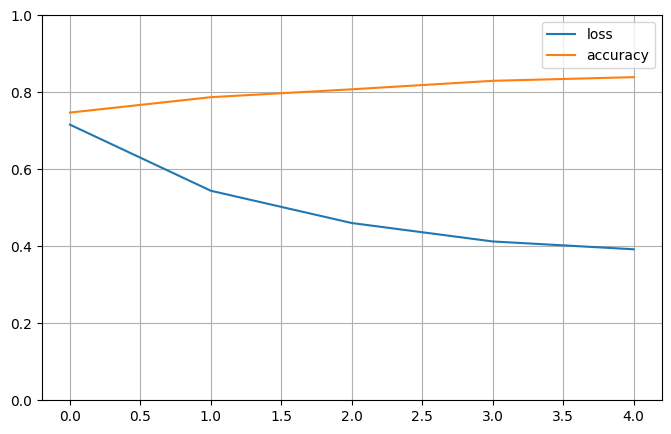

accuracy: 82.54%
2022-10-20 13:54:33.334834


In [12]:
print('splitting')
print(datetime.now())
data_partitions = splitter.get_train_valid_partitions(universe)
one_partition =data_partitions[0]
train_genes,valid_genes = one_partition[0],one_partition[1]
thresholds = splitter.choose_thresholds(train_genes,'one_z')
X_train,y_train = splitter.get_X_y(train_genes, thresholds)
X_valid,y_valid = splitter.get_X_y(valid_genes, thresholds)
print('Train sizes',len(X_train),len(y_train))
print('Valid sizes',len(X_valid),len(y_valid))

print('whacking')
print(datetime.now())
zero_unimportant_counts(X_train,sacred)
zero_unimportant_counts(X_valid,sacred)

print('Thresholds',thresholds)
print('Train set ones/size',
      np.count_nonzero(y_train),'/',len(y_train))
print('Valid set ones/size',
      np.count_nonzero(y_valid),'/',len(y_valid))

print("BUILD MODEL")
model=build_model()

print("FIT")
print(datetime.now())
history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
        epochs=EPOCHS, verbose=1)  # verbose=1 for ascii art, verbose=0 for none
        #validation_data=(X_valid,y_valid) )

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

scores = model.evaluate(X_valid, y_valid, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print(datetime.now())

In [13]:
# https://www.tensorflow.org/guide/variable
w=model.trainable_weights[0].numpy()  # weights
b=model.trainable_weights[1].numpy()  # bias
print('bias',b)
print(len(w),'weights min=',min(w),'max=',max(w))
ignored = list_Kmers_with_extreme_weights(w)

bias [0.8561143]
256 weights min= [-0.16147214] max= [0.15188865]
Extreme K-mers ['AAAA', 'AAAC', 'AAAG', 'AAAT', 'AACA', 'AACC', 'AACG', 'AACT', 'AAGA', 'AAGG', 'AAGT', 'AATA', 'AATC', 'AATG', 'AATT', 'ACAA', 'ACAG', 'ACAT', 'ACCA', 'ACCC', 'ACCG', 'ACCT', 'ACGC', 'ACGG', 'ACGT', 'ACTA', 'ACTC', 'ACTG', 'ACTT', 'AGAA', 'AGAG', 'AGAT', 'AGCA', 'AGCC', 'AGCG', 'AGCT', 'AGGA', 'AGGC', 'AGGG', 'AGGT', 'AGTA', 'AGTC', 'AGTG', 'AGTT', 'ATAA', 'ATAC', 'ATAG', 'ATAT', 'ATCC', 'ATCT', 'ATGA', 'ATGC', 'ATGG', 'ATGT', 'ATTA', 'ATTC', 'ATTG', 'ATTT', 'CAAA', 'CAAC', 'CAAG', 'CAAT', 'CACA', 'CACC', 'CACG', 'CACT', 'CAGA', 'CAGC', 'CAGG', 'CAGT', 'CATA', 'CATC', 'CATG', 'CATT', 'CCAA', 'CCAG', 'CCAT', 'CCCA', 'CCCC', 'CCCG', 'CCCT', 'CCGC', 'CCGT', 'CCTC', 'CCTG', 'CCTT', 'CGAA', 'CGAC', 'CGAT', 'CGCA', 'CGCG', 'CGCT', 'CGGA', 'CGGC', 'CGGG', 'CGGT', 'CGTA', 'CGTC', 'CGTG', 'CGTT', 'CTAA', 'CTAC', 'CTAG', 'CTAT', 'CTCA', 'CTCC', 'CTCG', 'CTCT', 'CTGA', 'CTGC', 'CTGG', 'CTGT', 'CTTA', 'CTTC', 'CTTG'

## Train and validate with very few K-mer counts

In [47]:
def zero_many_counts(rows,mod):
    counts = len(rows[0])
    for r in range(len(rows)):
        for c in range(counts):
            if c%mod != 0:
                rows[r][c]=0

splitting
2022-10-20 14:10:09.245086
Train sizes 12019 12019
Valid sizes 2795 2795
scaling
2022-10-20 14:10:09.373373
Thresholds (-1.266972910885237, 1.1401767974371442)
2022-10-20 14:10:10.712383
Train set ones/size 5469 / 12019
Valid set ones/size 1418 / 2795
BUILD MODEL
2022-10-20 14:10:10.712675
COMPILE...
...COMPILED
FIT
2022-10-20 14:10:10.727248
Epoch 1/5
376/376 [==============================] - 1s 2ms/step - loss: 0.5691 - accuracy: 0.7231
Epoch 2/5
376/376 [==============================] - 1s 2ms/step - loss: 0.4841 - accuracy: 0.7754
Epoch 3/5
376/376 [==============================] - 1s 2ms/step - loss: 0.4606 - accuracy: 0.7911
Epoch 4/5
376/376 [==============================] - 1s 2ms/step - loss: 0.4480 - accuracy: 0.7988
Epoch 5/5
376/376 [==============================] - 1s 2ms/step - loss: 0.4406 - accuracy: 0.8031


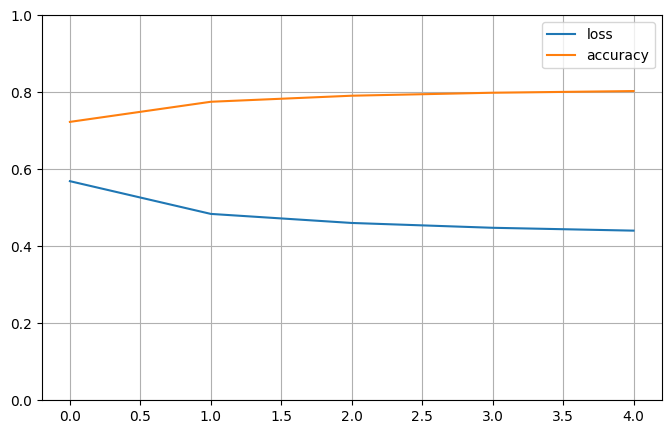

accuracy: 81.65%
2022-10-20 14:10:15.442165


In [51]:
from sklearn.preprocessing import StandardScaler

print('splitting')
print(datetime.now())
data_partitions = splitter.get_train_valid_partitions(universe)
one_partition =data_partitions[0]
train_genes,valid_genes = one_partition[0],one_partition[1]
thresholds = splitter.choose_thresholds(train_genes,'one_z')
X_train,y_train = splitter.get_X_y(train_genes, thresholds)
X_valid,y_valid = splitter.get_X_y(valid_genes, thresholds)
print('Train sizes',len(X_train),len(y_train))
print('Valid sizes',len(X_valid),len(y_valid))

print('scaling')
print(datetime.now())
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
zero_many_counts(X_train,10)
zero_many_counts(X_valid,10)

print('Thresholds',thresholds)
print(datetime.now())
print('Train set ones/size',
      np.count_nonzero(y_train),'/',len(y_train))
print('Valid set ones/size',
      np.count_nonzero(y_valid),'/',len(y_valid))

print("BUILD MODEL")
print(datetime.now())
model=build_model()

print("FIT")
print(datetime.now())
history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
        epochs=EPOCHS, verbose=1)  # verbose=1 for ascii art, verbose=0 for none
        #validation_data=(X_valid,y_valid) )

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

scores = model.evaluate(X_valid, y_valid, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print(datetime.now())

In [52]:
for row in X_train[:10]:
    for v in row[:40]:
        print(v,end=' ')
    print()

0.7417897730800902 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.6096975328885512 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.4709104971514866 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.5790313884988391 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
-0.1420689457439131 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.7051732813744213 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.11576698870958556 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.5790313884988391 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.5650180293152894 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.6096975328885512 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1775717542209505 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.3533157229392008 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.4766321574328891 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.32327028743094105 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.7024444745706577 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.6918892212786582 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.4766321574328891 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.32327028743094105 0.0 0.0 0.0 0.0 0.0 0.0 0.0